In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import sys

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")

In [4]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '04d_clustering_compare_after_removal'    # name of notebook

In [5]:
save = True

In [6]:
def dump_figure(name):
    if save:
        export.image(
            user,
            f'{outfolder}/{name}',
        )
        
        
def dump_raster_figure(name):
    if save:
        export.raster_image(
            user,
            f'{outfolder}/{name}',
            dpi=300
        )        

In [7]:
number_of_clusters = 14

In [8]:
p_in = inout.get_material_path(f'{user}/04c_clustering_stability_against_removal/assignments')

In [9]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(p_in) if isfile(join(p_in, f))]

In [10]:
agg = []
for file in [x for x in onlyfiles if x.endswith('.csv')]:
    p = os.path.join(p_in, file)
    agg.append(pd.read_csv(p))

In [11]:
df = pd.concat(agg)

In [12]:
d = df[df['max_cluster']==number_of_clusters]

In [13]:
d = d.pivot(index='pt_day', columns='dropped_patient', values='cluster_order')

In [14]:
medians = d.median(1)

In [15]:
for c in d.columns:
    f = d.loc[:, c].isnull()
    d.loc[f, c] = medians[f]

In [16]:
d = d+1   # same ordering as main figures

/Users/tstoeger/opt/miniconda3/envs/cereal/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


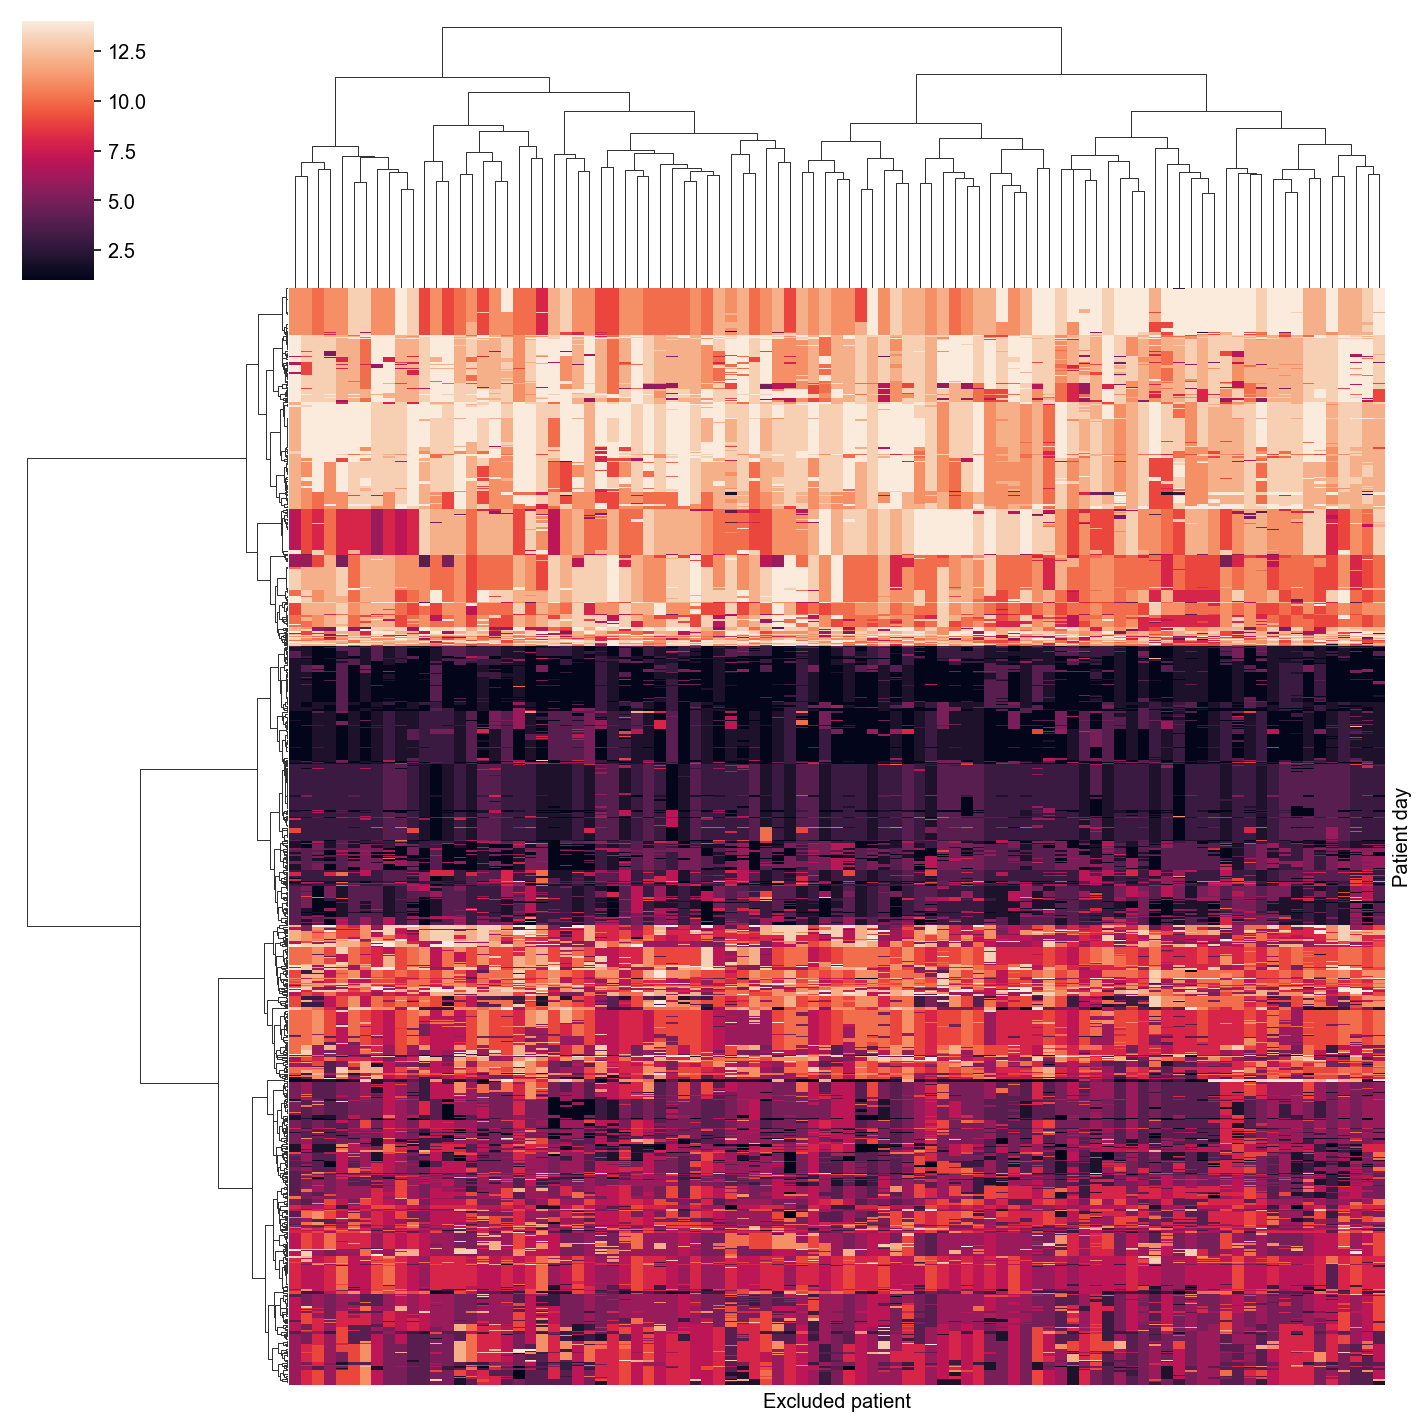

In [17]:
sns.clustermap(d.rename_axis(index='Patient day', columns='Excluded patient'), method='ward', xticklabels=False, yticklabels=False)

dump_raster_figure('meta_cluster.png')
dump_figure('meta_cluster.pdf')


In [18]:
number_of_clusters = 14

In [19]:
d = df[df['max_cluster']==number_of_clusters]

In [20]:
dp = d['dropped_patient'].unique()

In [21]:
from itertools import product

In [22]:
results = pd.DataFrame(index=dp, columns=dp)

In [23]:
for dp_1, dp_2 in product(dp, dp):
    
    if dp_2 >= dp_1:
        continue

    cis = d[d['dropped_patient']==dp_1]
    trans = d[d['dropped_patient']==dp_2]

    cis = cis[cis['Patient_id'] != dp_2]
    trans = trans[trans['Patient_id'] != dp_1]

    helper = pd.merge(
        cis[['pt_day', 'cluster_order']],
        trans[['pt_day', 'cluster_order']],
        on='pt_day',
        suffixes=('_cis', '_trans')
    ).groupby(['cluster_order_cis', 'cluster_order_trans']).size().to_frame('intersection').reset_index()

    helper = pd.merge(
        helper,
        cis['cluster_order'].value_counts().to_frame('in_cis_cluster').rename_axis('cluster_order_cis').reset_index()

    )



    helper = pd.merge(
        helper,
        trans['cluster_order'].value_counts().to_frame('in_trans_cluster').rename_axis('cluster_order_trans').reset_index()

    )

    helper.loc[:, 'jaccard'] = helper['intersection'] / (helper['in_cis_cluster'] + helper['in_trans_cluster'] - helper['intersection'])

    h = helper.pivot(index='cluster_order_cis', columns='cluster_order_trans', values='jaccard').fillna(0)

    a = pd.merge(
        helper.sort_values('jaccard', ascending=False).drop_duplicates('cluster_order_cis', keep='first')[['cluster_order_cis', 'cluster_order_trans']],
        helper.sort_values('jaccard', ascending=False).drop_duplicates('cluster_order_trans', keep='first')[['cluster_order_cis', 'cluster_order_trans']],
        on='cluster_order_cis'
    )

    share_best = (a['cluster_order_trans_x'] == a['cluster_order_trans_y']).mean()
    
    results.loc[dp_1, dp_2] = share_best

/Users/tstoeger/opt/miniconda3/envs/cereal/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


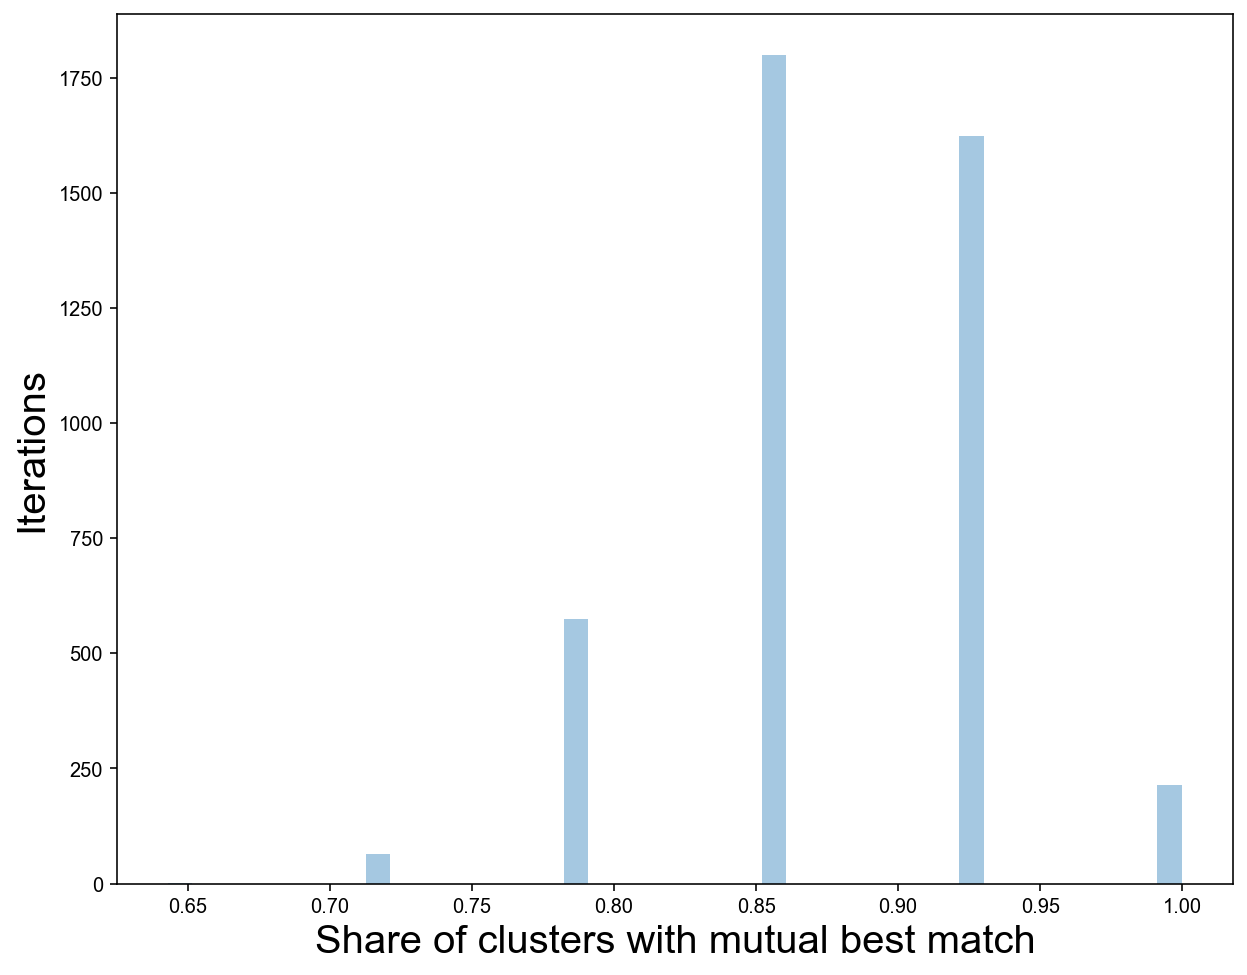

In [24]:
sns.distplot(results.stack(), kde=False)
plt.xlabel('Share of clusters with mutual best match', fontsize=20)
plt.ylabel('Iterations', fontsize=20)
dump_figure('frequencies.pdf')